In [1]:
# Librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Attention, Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Lista de criptos
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'SOL-USD', 'DOT-USD']

# Descargar los datos de los últimos 2 años con intervalos de 1 hora y combinarlos
data = {}
for crypto in cryptos:
    data[crypto] = yf.download(crypto, period='2y', interval='1h')

# Crear DataFrame con los valores de cierre
prices = pd.DataFrame({crypto: data[crypto]['Close'] for crypto in cryptos})

# Convertir DataFrame a una matriz NumPy
prices_matrix = prices.to_numpy()

# Escalar los datos
scaler = MinMaxScaler()
prices_matrix_scaled = scaler.fit_transform(prices_matrix)

# Verificar si hay valores NaN
nan_mask = np.isnan(prices_matrix_scaled)
if np.any(nan_mask):
    print("\nHay valores NaN en la matriz escalada.")
    # Reemplazar NaNs con la media de los valores anterior y siguiente
    indices = np.arange(prices_matrix_scaled.shape[0])
    # Iterar sobre cada columna
    for col in range(prices_matrix_scaled.shape[1]):
        # Obtener los índices de los NaNs en la columna
        nan_indices = np.where(nan_mask[:, col])[0]
        # Reemplazar NaNs
        for idx in nan_indices:
            # Valores anterior y siguiente
            prev_value = prices_matrix_scaled[idx - 1, col] if idx > 0 else np.nan
            next_value = prices_matrix_scaled[idx + 1, col] if idx < len(prices_matrix_scaled) - 1 else np.nan
            # Calcular la media de los valores anterior y siguiente
            if not np.isnan(prev_value) and not np.isnan(next_value):
                prices_matrix_scaled[idx, col] = (prev_value + next_value) / 2
            elif not np.isnan(prev_value):
                prices_matrix_scaled[idx, col] = prev_value
            elif not np.isnan(next_value):
                prices_matrix_scaled[idx, col] = next_value
            else:
                # Si ambos son NaN, dejar NaN (aunque esto debería ser raro)
                prices_matrix_scaled[idx, col] = np.nan

    # Verificar nuevamente si hay valores NaN
    if np.any(np.isnan(prices_matrix_scaled)):
        print("Después de reemplazar, aún hay valores NaN en la matriz escalada.")
    else:
        print("Todos los valores NaN han sido reemplazados.")
else:
    print("No hay valores NaN en la matriz escalada.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Hay valores NaN en la matriz escalada.
Todos los valores NaN han sido reemplazados.


In [3]:
# con esta función se van a crear las series de longitud 100 y se
# separan en x: S[0:T-t] e y: S[T-t: T]
def create_series(data, T=100, t=5):
    X, y = [], []
    for i in range(len(data) - T):
        X.append(data[i:i + T - t])
        y.append(data[i + T - t:i + T])
    return np.array(X), np.array(y)

In [4]:
input_dim = 7
units = 64
T = 100
t = 5

# para en encoder
encoder_in = Input(shape=(T-t, input_dim))
encoder_rnn = LSTM(units, return_sequences=True, return_state=True)
encoder_out, state_h, state_c = encoder_rnn(encoder_in)


# para el decoder
decoder_in = Input(shape=(t, input_dim))
decoder_rnn = LSTM(units, return_sequences=True, return_state=True)
decoder_out, _, _ = decoder_rnn(decoder_in, initial_state=[state_h, state_c])

# para la atención
attention = Attention()
attention_out = attention([decoder_out, encoder_out])

# unimos la salida del decoder y de la capa de atención y obtenemos resultados con una capa densa
combined_out = Concatenate(axis=-1)([decoder_out, attention_out])
dense = Dense(input_dim)
pred = dense(combined_out)

# definimos el modelo seq2seq
seq2seq = Model([encoder_in, decoder_in], pred)

seq2seq.compile(optimizer='adam', loss='mse')
seq2seq.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 95, 7)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 5, 7)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 95, 64),       │         18,432 │ input_layer[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 5, 64), (None, │         18,432 │ input_layer_1[0][0],   │
│                           │ 64), (None, 64)]       │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 5, 64)          │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5, 128)         │              0 │ lstm_1[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5, 7)           │            903 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 37,767 (147.53 KB)

 Trainable params: 37,767 (147.53 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def plot_sequences(true_sequence, predicted_sequence, num_features=7, num = 0):
  for index in range(5):
    plt.plot(true_sequence[index, :, num], label='Real')
    plt.plot(predicted_sequence[index, :, num], label='Predicción')
    plt.title('Secuencias')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
X1, y1 = create_series(prices_matrix)
X, y = create_series(prices_matrix_scaled)
print("Checking for NaNs in X:", np.isnan(X).any())
print("Checking for NaNs in y:", np.isnan(y).any())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Checking for NaNs in X: False
Checking for NaNs in y: False


Esta parte nos muestra un poco sobre la variabilidad de las secuencias que se tienen. De donde se puede ver que, hay una variabilidad considerable en las secuencias, lo que puede afectar considerablemente las salidas.

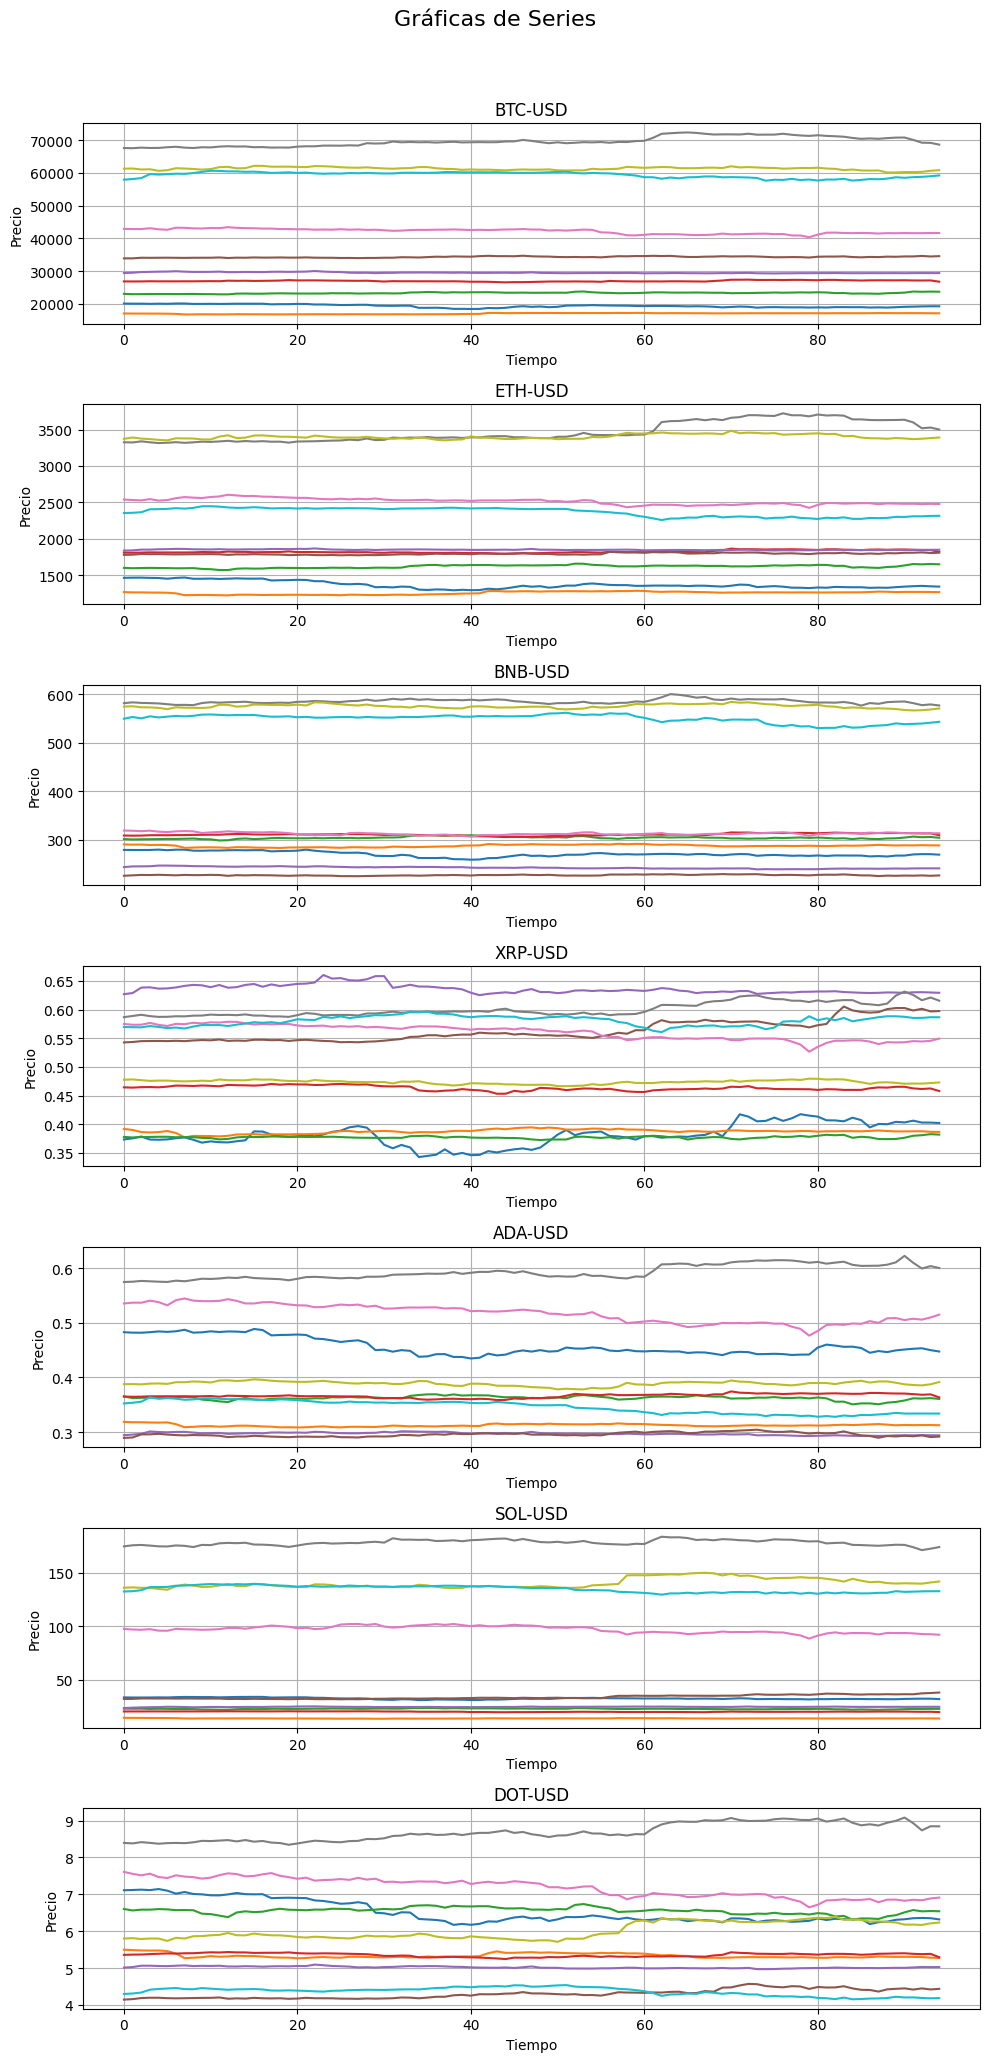

In [7]:
def plot_series(X, num = 10):
    num_series = X.shape[0]
    num_columns = X.shape[2]

    fig, axes = plt.subplots(nrows=num_columns, figsize=(10, num_columns * 3))
    fig.suptitle('Gráficas de Series', fontsize=16)

    for col in range(num_columns):
        series_col = X[:, :, col]
        selected = np.linspace(0, num_series-1, num, dtype=int)
        for i in selected:
          x_range = np.arange(series_col.shape[1])
          axes[col].plot(x_range, series_col[i])

        axes[col].set_title(f'{cryptos[col]}')
        axes[col].set_xlabel('Tiempo')
        axes[col].set_ylabel('Precio')
        axes[col].grid()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
decoder_input = y_test
plot_series(X1)

In [8]:
seq2seq.fit(
    [X_train, y_train],
    y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - loss: 0.0174 - val_loss: 5.1981e-04
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - loss: 4.0354e-04 - val_loss: 2.5382e-04
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - loss: 2.0737e-04 - val_loss: 2.0583e-04
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 1.5552e-04 - val_loss: 1.5764e-04
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - loss: 1.2901e-04 - val_loss: 1.3038e-04
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - loss: 1.1011e-04 - val_loss: 1.0317e-04
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 8.9826e-05 - val_loss: 8.0873e-05
Epoch 8/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 6.9598e-05 - val_loss: 7.8786e-05
Epoch 9/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 5.9989e-05 - val_loss: 6.9077e-05
Epoch 10/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - loss: 5.3082e-05 - val_loss: 8.0117e-05
Epoch 11/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 1

In [9]:
predictions = seq2seq.predict([X_test, decoder_input])

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


Observación de los resultados obtenidos.

Para bitcoin.

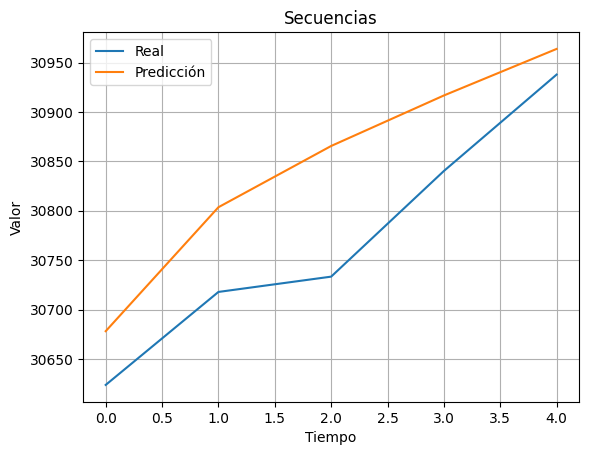

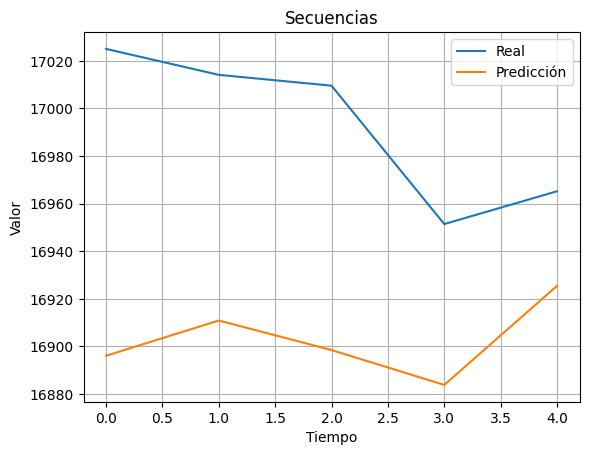

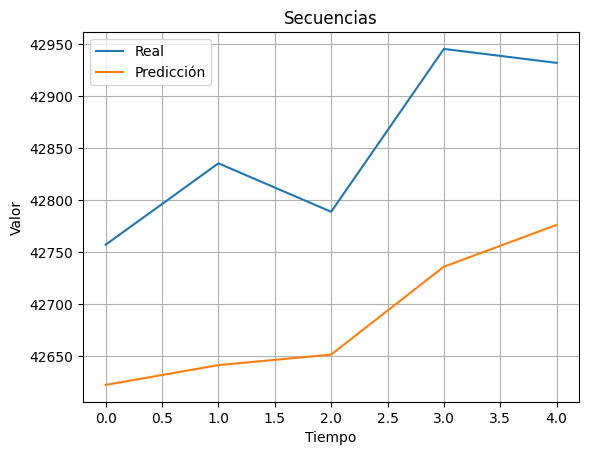

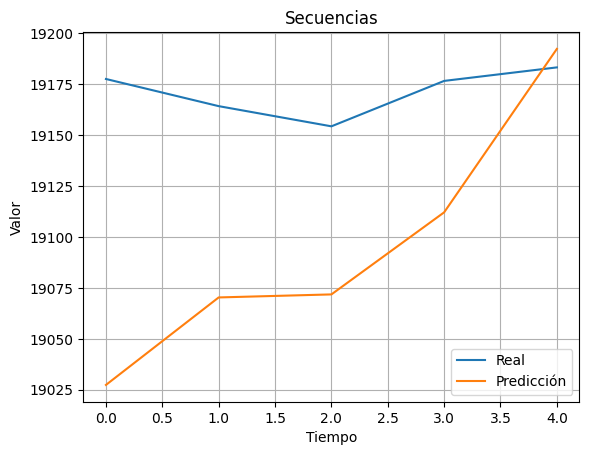

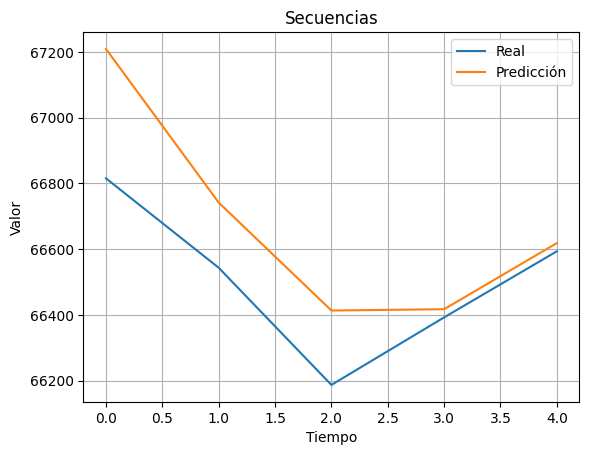

In [10]:
predictions_rescaled = []
y_test_rescaled = []
for i in range(len(predictions)):
  predictions_rescaled.append(scaler.inverse_transform(predictions[i]))
  y_test_rescaled.append(scaler.inverse_transform(y_test[i]))
predictions_rescaled = np.array(predictions_rescaled)
y_test_rescaled = np.array(y_test_rescaled)
plot_sequences(y_test_rescaled, predictions_rescaled, num_features=input_dim)

Para ethereum

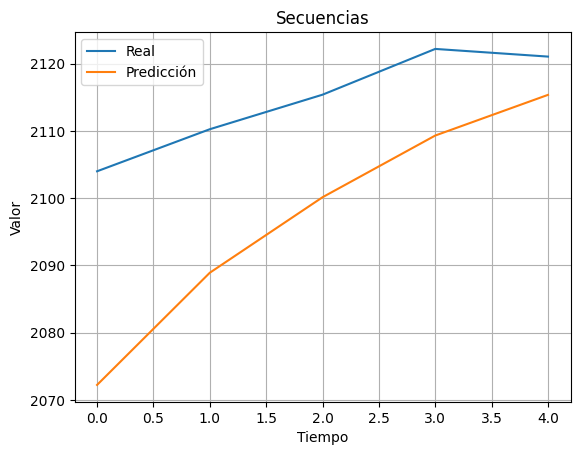

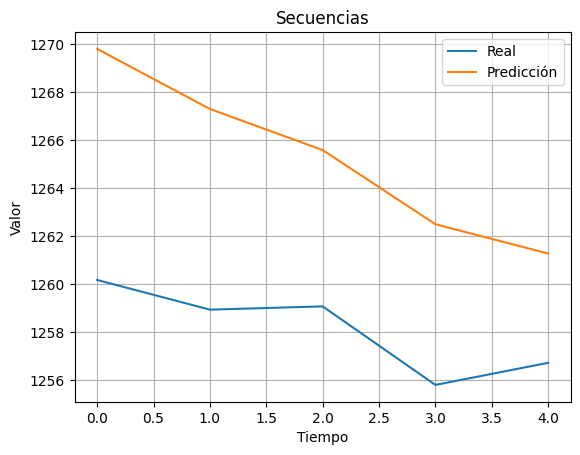

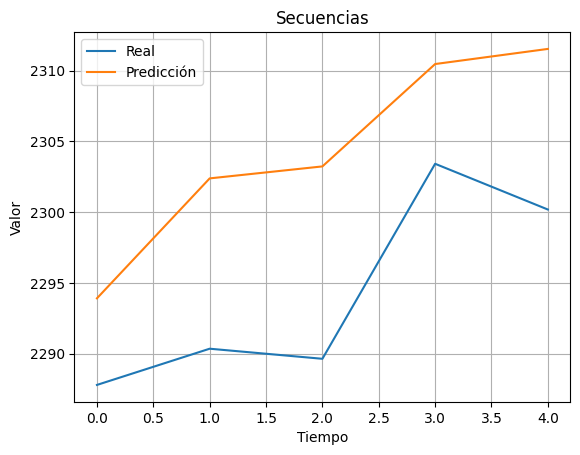

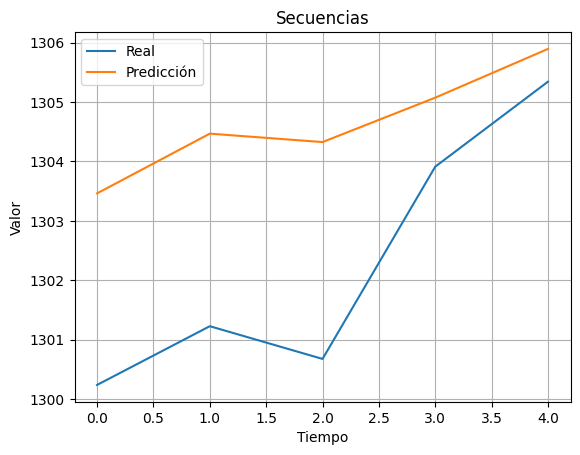

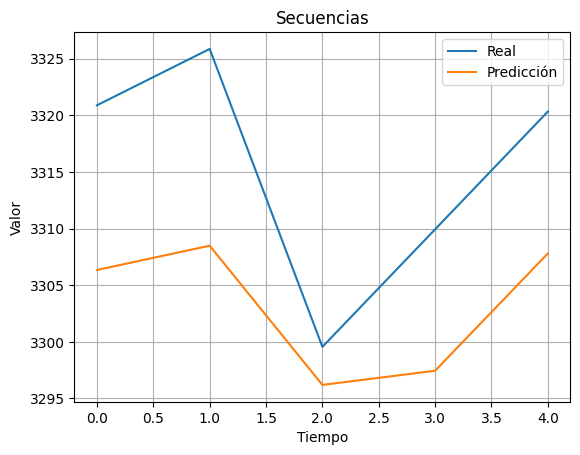

In [11]:
plot_sequences(y_test_rescaled, predictions_rescaled, num_features=input_dim, num = 1)

Para la última moneda (valores muy bajos de precio)

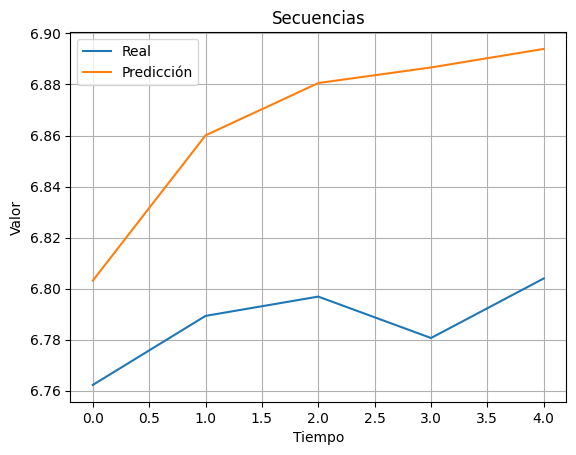

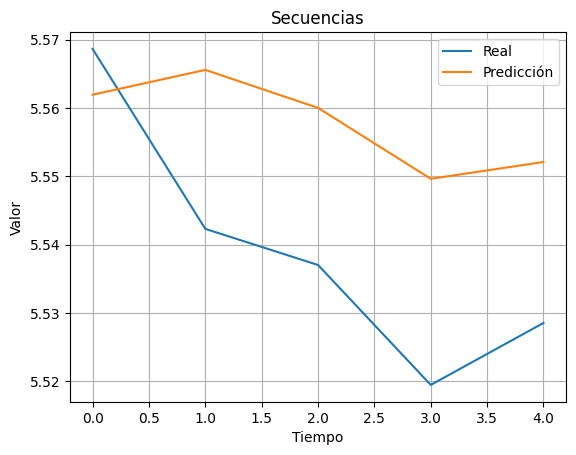

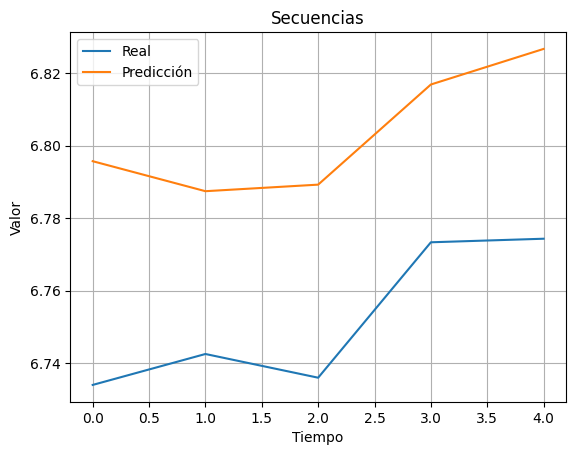

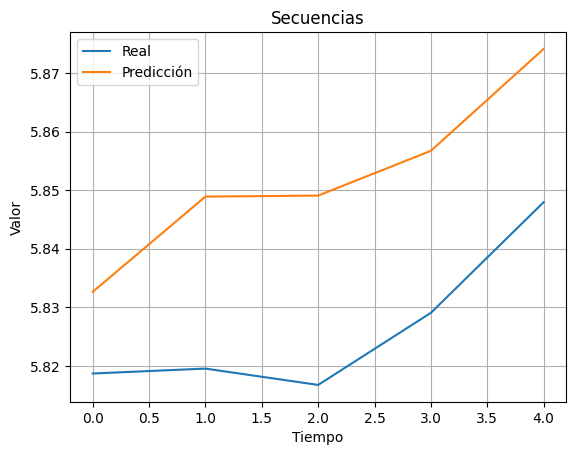

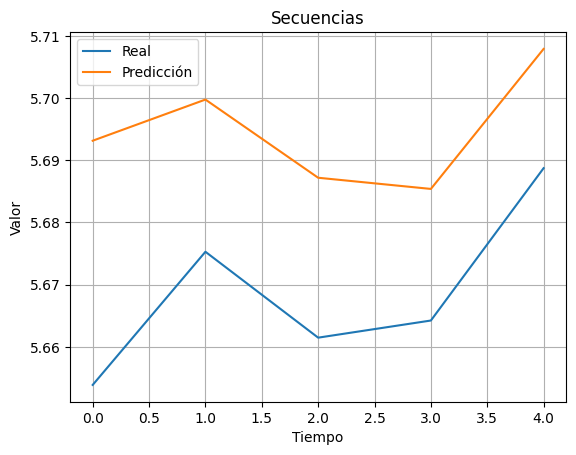

In [12]:
plot_sequences(y_test_rescaled, predictions_rescaled, num_features=input_dim, num = -1)